# Mesh Construction

This tutorial introduces the construction and manipulation of curvilinear 
meshes.

A `PlanarMesh` object is fundamentally a list of curvilinear `Edge` objects.
Each edge consists of a pair of vertices and enough information to 
parameterize the edge as a curve in the plane. Each edge also is assigned to 
two mesh cells to which the edge is part of the boundary. 
One of these cells is taken to be "positive" and the other "negative."
For the positive cell, the edge is oriented counterclockwise if it lies on the 
outer boundary of the cell (i.e. the edge is not the boundary of a hole in the
cell), and clockwise otherwise. For the negative cell, the opposite is true.
In this fashion, the entire mesh can be constructed from a list of edges.

We begin by importing the `puncturedfem` package, 
as well as `numpy` and `matplotlib` for the sake of this example.

In [31]:
import sys
import os

current_dir = os.getcwd()
parent_dir = os.path.abspath(os.path.join(current_dir, ".."))
sys.path.append(parent_dir)

import puncturedfem as pf
import numpy as np
import matplotlib.pyplot as plt

## Creating an edge
The simplest type of edge is a straight line segment, which is the default
when initializing an `edge` object.

In [32]:
# define vertices
v1 = pf.Vert(x=0.0, y=0.0)
v2 = pf.Vert(x=1.0, y=2.0)

# define a straight edge
e1 = pf.Edge(v1, v2)

For curvilinear edges, we can supply additional arguments to define the edge.
The `curvetype` string is the name of a module located in
```puncturedfem/mesh/edgelib```
where the functions defining the parameterization of this curve are located.
We can also pass in any keyword arguments used to define the edge.

For instance, we can create a circular arc corresponding to a $120^\circ$ angle
as follows:

In [33]:
# create a circular arc
e2 = pf.Edge(v1, v2, curve_type="circular_arc_deg", theta0=120)

Some of the common `curvetype`s used in these examples are

|`curvetype` 		| keyword argument(s) 	|
|-------------------|-----------------------|
|`'circle'`			| `'radius'`			|
|`'circular_arc'`	| `'theta0'`			|
|`'ellipse'`		|`'a'`, `'b'`			|
|`'line'`			|						|
|`'sine_wave'`		|`'amp'`, `'freq'`		|

To define a custom `curvetype`, see the appendix at the end of this notebook.

## Parameterizing an edge with `quad` objects
To create the points $0=t_0 < t_1 < \cdots < t_{2n}=2\pi$ where $x(t)$ 
will be sampled, we will declare a quadrature scheme with a `quad` object.
For now, we will use the trapezoid rule, which uses the equispacing 
$t_k = hk$, where $h=\pi / n$ for a chosen natural number $n$.

In [34]:
n = 32
q_trap = pf.Quad(qtype="trap", n=n)
q_kress = pf.Quad(qtype="kress", n=n)
quad_dict = {"kress": q_kress, "trap": q_trap}

The points for the trapezoidal (`'trap'`) quadrature scheme are,
of course, sampled at equidistance nodes. The Kress (`'kress'`) 
quadrature should be used to parameterized edges that terminate at a corner.
Since this is the most common case, it is the default method to parameterize 
an edge.
We can see that the Kress scheme samples points more heavily near the endpoints: 

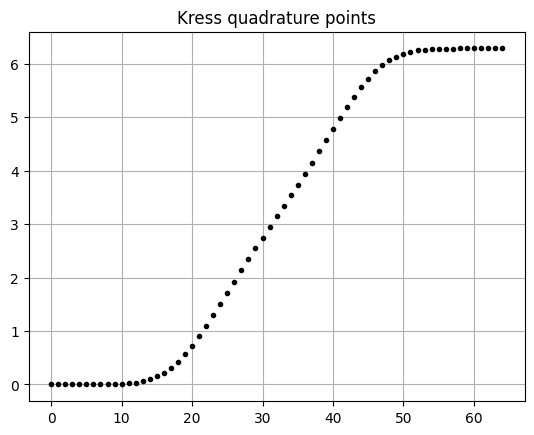

In [35]:
plt.figure()
plt.plot(q_kress.t, "k.")
plt.title("Kress quadrature points")
plt.grid("on")
plt.show()

We are now prepared to parameterize our edges.

In [36]:
e1.parameterize(quad_dict)
e2.parameterize(quad_dict)

We can plot the edges using the `MeshPlot` class:

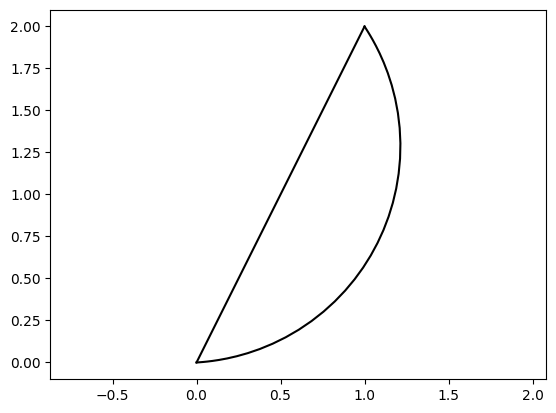

In [37]:
pf.plot.MeshPlot([e1, e2]).draw()

We can visualize the orientation of each edge by setting the 
`show_orientation` keyword argument to `True`. 
We can also introduce grid lines by setting the `show_grid` keyword argument
to `True`.

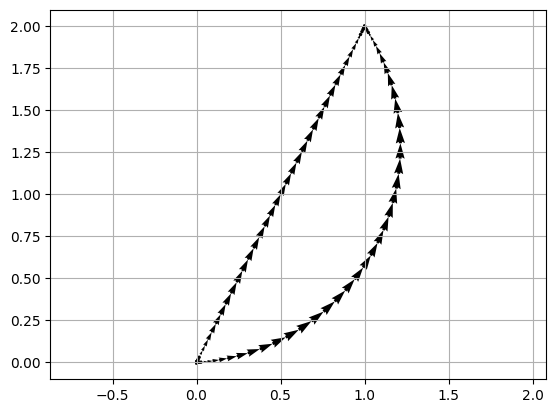

In [38]:
pf.plot.MeshPlot([e1, e2], show_orientation=True, show_grid=True).draw()

## Creating a mesh

First we begin by defining the vertices of the mesh.

In [39]:
verts: list[pf.Vert] = []

# rectangle corners
verts.append(pf.Vert(x=0.0, y=0.0))  # 0
verts.append(pf.Vert(x=1.0, y=0.0))  # 1
verts.append(pf.Vert(x=3.0, y=0.0))  # 2
verts.append(pf.Vert(x=4.0, y=0.0))  # 3
verts.append(pf.Vert(x=4.0, y=1.0))  # 4
verts.append(pf.Vert(x=3.0, y=1.0))  # 5
verts.append(pf.Vert(x=1.0, y=1.0))  # 6
verts.append(pf.Vert(x=0.0, y=1.0))  # 7

# pacman
pacman_scale = 0.4
verts.append(pf.Vert(x=0.5, y=0.5))  # 8
verts.append(
    pf.Vert(x=0.5 + pacman_scale * (np.sqrt(3) / 2), y=0.5 + pacman_scale * 0.5)
)  # 9
verts.append(
    pf.Vert(x=0.5 + pacman_scale * (np.sqrt(3) / 2), y=0.5 - pacman_scale * 0.5)
)  # 10
verts.append(
    pf.Vert(x=0.5 + pacman_scale * -0.1, y=0.5 + pacman_scale * 0.5)
)  # 11

# dots
verts.append(pf.Vert(x=1.5, y=0.5))  # 12
verts.append(pf.Vert(x=2.0, y=0.5))  # 13
verts.append(pf.Vert(x=2.5, y=0.5))  # 14

# ghost
ghost_scale = 0.6
ghost_x_shift = 3.5
ghost_y_shift = 0.5
verts.append(
    pf.Vert(
        x=ghost_x_shift + ghost_scale * (-0.5),
        y=ghost_y_shift + ghost_scale * (-0.6),
    )
)  # 15
verts.append(
    pf.Vert(
        x=ghost_x_shift + ghost_scale * (0.5),
        y=ghost_y_shift + ghost_scale * (-0.6),
    )
)  # 16
verts.append(
    pf.Vert(
        x=ghost_x_shift + ghost_scale * (0.5),
        y=ghost_y_shift + ghost_scale * (0.2),
    )
)  # 17
verts.append(
    pf.Vert(
        x=ghost_x_shift + ghost_scale * (-0.5),
        y=ghost_y_shift + ghost_scale * (0.2),
    )
)  # 18
verts.append(
    pf.Vert(
        x=ghost_x_shift + ghost_scale * (-0.25),
        y=ghost_y_shift + ghost_scale * (0.1),
    )
)  # 19
verts.append(
    pf.Vert(
        x=ghost_x_shift + ghost_scale * (0.25),
        y=ghost_y_shift + ghost_scale * (0.1),
    )
)  # 20

We need to label our vertices:

In [40]:
# TODO: future versions should do this automatically.
for k in range(len(verts)):
    verts[k].set_idx(k)

Let's visualized these points:

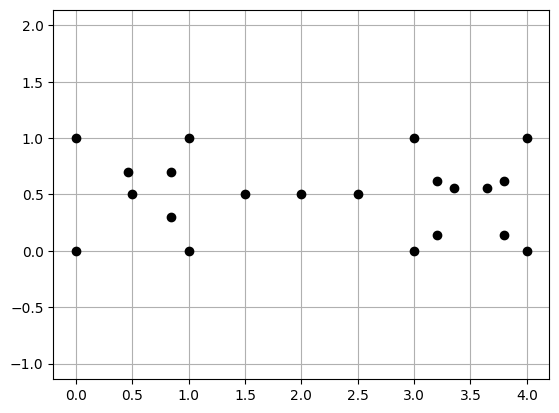

In [41]:
plt.figure()
for v in verts:
    plt.plot(v.x, v.y, "ko")
plt.axis("equal")
plt.grid("on")
plt.show()

Next, we define the edges.
The parameter `pos_cell_idx` is the index of the cell with this edge oriented
counterclockwise on the outer boundary (or clockwise if on a hole boundary).
In the event that this edge lies on the boundary of the domain and there is 
no such cell, `pos_cell_idx = -1` is taken as the default argument.
The `neg_cell_idx` is the index of the cell where the opposite is true. 

In [42]:
edges: list[pf.Edge] = []

# rectangles
edges.append(pf.Edge(verts[0], verts[1], pos_cell_idx=0))
edges.append(pf.Edge(verts[1], verts[2], pos_cell_idx=3))
edges.append(pf.Edge(verts[2], verts[3], pos_cell_idx=7))
edges.append(pf.Edge(verts[3], verts[4], pos_cell_idx=7))
edges.append(pf.Edge(verts[4], verts[5], pos_cell_idx=7))
edges.append(pf.Edge(verts[5], verts[6], pos_cell_idx=3))
edges.append(pf.Edge(verts[6], verts[7], pos_cell_idx=0))
edges.append(pf.Edge(verts[7], verts[0], pos_cell_idx=0))
edges.append(pf.Edge(verts[1], verts[6], pos_cell_idx=0, neg_cell_idx=3))
edges.append(pf.Edge(verts[2], verts[5], pos_cell_idx=3, neg_cell_idx=7))

# pacman
edges.append(pf.Edge(verts[8], verts[9], pos_cell_idx=1, neg_cell_idx=0))
edges.append(
    pf.Edge(
        verts[9],
        verts[10],
        pos_cell_idx=1,
        neg_cell_idx=0,
        curve_type="circular_arc_deg",
        theta0=300,
    )
)
edges.append(pf.Edge(verts[10], verts[8], pos_cell_idx=1, neg_cell_idx=0))
edges.append(
    pf.Edge(
        verts[11],
        verts[11],
        pos_cell_idx=2,
        neg_cell_idx=1,
        curve_type="circle",
        radius=0.25 * pacman_scale,
    )
)

# dots
edges.append(
    pf.Edge(
        verts[12],
        verts[12],
        pos_cell_idx=4,
        neg_cell_idx=3,
        curve_type="circle",
        radius=0.1,
    )
)
edges.append(
    pf.Edge(
        verts[13],
        verts[13],
        pos_cell_idx=5,
        neg_cell_idx=3,
        curve_type="circle",
        radius=0.1,
    )
)
edges.append(
    pf.Edge(
        verts[14],
        verts[14],
        pos_cell_idx=6,
        neg_cell_idx=3,
        curve_type="circle",
        radius=0.1,
    )
)

# ghost
edges.append(
    pf.Edge(
        verts[15],
        verts[16],
        pos_cell_idx=8,
        neg_cell_idx=7,
        curve_type="sine_wave",
        amp=0.1,
        freq=6,
    )
)
edges.append(pf.Edge(verts[16], verts[17], pos_cell_idx=8, neg_cell_idx=7))
edges.append(
    pf.Edge(
        verts[17],
        verts[18],
        pos_cell_idx=8,
        neg_cell_idx=7,
        curve_type="circular_arc_deg",
        theta0=180,
    )
)
edges.append(pf.Edge(verts[18], verts[15], pos_cell_idx=8, neg_cell_idx=7))
edges.append(
    pf.Edge(
        verts[19],
        verts[19],
        pos_cell_idx=9,
        neg_cell_idx=8,
        curve_type="ellipse",
        a=0.15 * ghost_scale,
        b=0.2 * ghost_scale,
    )
)
edges.append(
    pf.Edge(
        verts[20],
        verts[20],
        pos_cell_idx=10,
        neg_cell_idx=8,
        curve_type="ellipse",
        a=0.15 * ghost_scale,
        b=0.2 * ghost_scale,
    )
)

With all of the edges of the mesh defined, we are prepared to define a
`planar_mesh` object.

In [43]:
T = pf.PlanarMesh(edges)

Building planar mesh...
PlanarMesh:
	num_verts: 15
	num_edges: 23
	num_cells: 11


Let's visualize the mesh skeleton, but first we should remember to parameterize
the edges.

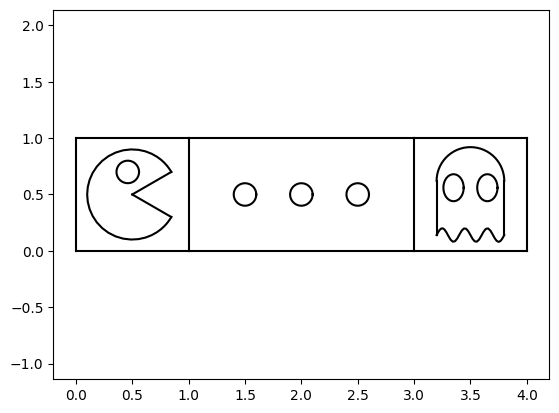

In [44]:
# parameterize all edges of the mesh
for e in T.edges:
    e.parameterize(quad_dict)

# plot the skeleton
pf.plot.MeshPlot(T.edges).draw()

Moreover, we can visualize an individual cell of the mesh:

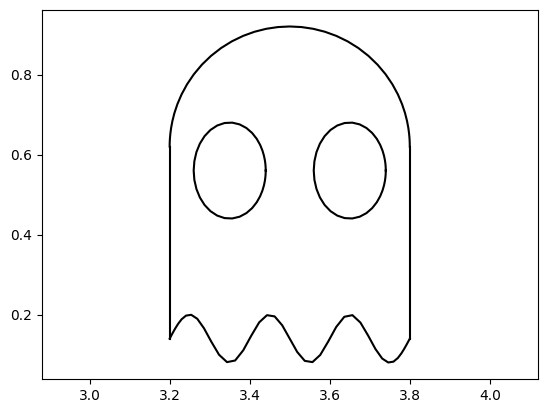

In [47]:
cell_idx = 8
K = T.get_cells(cell_idx)
pf.plot.MeshPlot(K.get_edges()).draw()

## Appendix: Defining a custom `curvetype`
An edge $e$ is taken to be a $C^2$ smooth curve in $\mathbb{R}^2$
parameterized by $x(t)$ for $0\leq t\leq 2\pi$.
We refer to $x(0)$ as the *anchor point* and $x(2\pi)$ as the 
*terminal point*, and $x(0),x(2\pi)$ are referred to collectively as the 
*endpoints*. We make the following assumptions:
* The edge $e$ is nontrivial: $e$ is not a single point.
* The edge $e$ is nonselfintersecting: $x(t_1)\neq x(t_2)$ 
  for all $0<t_1<t_2<2\pi$.
* $x(\cdot)$ is regularizable: there is some fixed $\sigma>0$ such that
  $|x'(t)|\geq\sigma$ for all $0 < t < 2\pi$.

In the event that we need an edge that is not provided in the 
`puncturedfem/mesh/edgelib` folder,
we can add to the edge library as follows. 
1. Create a file `puncturedfem/mesh/edgelib/mycurve.py`, where `mycurve` will
   be the name of the curve that will be called during the initialization 
   of the edge object. 
2. Import the `numpy` package.
3. In `mycurve.py`, define three functions called `X()`, `DX()`, and `DDX()`.
   These will define $x(t)$, $x'(t)$, and $x''(t)$ respectively.
4. Each of these three functions will return a $2\times (2n+1)$ array,
   where $2n+1$ is the number of sampled points specified by the chosen
   `Quad` object.
5. Row 0 of each array contains the $x_1$ component, and row 1 contains the 
   $x_2$ component.
6. Unpack any additional arguments from `**kwargs`.

The contents of `mycurve.py` will look generically like the following:

	"""
	A short description of the curve.

	A description of any parameters that are used.
	"""

	import numpy as np

	def X(t, **kwargs):

		my_parameter = kwargs['my_parameter']

		x = np.zeros((2,len(t)))
		x[0,:] = 	# the x_1 component
		x[1,:] = 	# the x_2 component

		return x

	def DX(t, **kwargs):

		my_parameter = kwargs['my_parameter']

		dx = np.zeros((2,len(t)))
		dx[0,:] = 	# the derivative of the x_1 component wrt t
		dx[1,:] = 	# the derivative of the x_2 component wrt t

		return dx

	def DDX(t, **kwargs):

		my_parameter = kwargs['my_parameter']

		ddx = np.zeros((2,len(t)))
		ddx[0,:] = 	# the second derivative of the x_1 component wrt t
		ddx[1,:] = 	# the second derivative of the x_2 component wrt t
		
		return ddx